# Spark Initialization

In [1]:
import ast
import atexit
import io
import itertools
import json
import os
import re
import sys
import uuid
from datetime import datetime

from IPython.display import HTML, display

if "spark" not in vars():
    import findspark

    findspark.init()
    import pyspark.sql.functions as F
    import pyspark.sql.types as T
    from pyspark.sql import DataFrame, SparkSession
    from pyspark.sql.window import Window
    from pyspark.storagelevel import StorageLevel

    spark = (
        SparkSession.builder.master("local[8,2]")
        .config("spark.driver.memory", "1g")
        .enableHiveSupport()
        .getOrCreate()
    )
    atexit.register(lambda: spark.stop())

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import DataFrame, Row, SparkSession
from pyspark.sql.window import Window


def cleanse_val(val):
    return re.sub(r"([^\s\w\d])+", "", val.lower()).strip() if val else ""


def reg(spark_df, name=None):
    uniqsig = "df_{0}".format(cleanse_val(str(uuid.uuid4()))) if not name else name
    spark_df.createOrReplaceTempView(uniqsig)
    return uniqsig


def show(df, rows=5):
    display(df.limit(rows).toPandas())


# Override table show/registration functions
DataFrame.reg = reg
DataFrame.dshow = show

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/07 23:47:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/03/07 23:47:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Hadoop Utilities

In [2]:
sc = spark.sparkContext

import os

from pyspark import *
from pyspark.sql import *

_conf = sc._jsc.hadoopConfiguration()
# Get Spark/Hadoop file system
_fs = sc._jvm.org.apache.hadoop.fs.FileSystem.get(_conf)


# Return HDFS Path object from String
def _path(path):
    return sc._jvm.org.apache.hadoop.fs.Path(path)


# Given a HDFS directory path, report number of containers that can ideally process this "chunk" of work unit
def _blocks(path):
    return round(0.5 + _fs.getUsed(_path(path)) / _fs.getDefaultBlockSize(_path(path)))


# List files of a HDFS path
def _listFiles(path):
    return [file.getPath().toString() for file in _fs.globStatus(_path(path))]


# Compute a unique file ID for every HDFS path
def _fileid(path):
    return str(abs(hash(os.path.basename(path))))


# Duplicate processable objects to a temporary directory (helps keep the processes consistent)
def _moveFiles(paths, dest, delete_source=False):
    return {
        _fileid(path): path
        for path in paths
        if sc._jvm.org.apache.hadoop.fs.FileUtil.copy(
            _fs,
            _path(path),
            _fs,
            _path(f"{dest}/{_fileid(path)}"),
            delete_source,
            True,
            _conf,
        )
    }

24/03/07 23:47:46 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


# Data Integration from Web

In [3]:
import pandas as pd

airports = spark.createDataFrame(
    pd.read_csv(
        "http://ourairports.com/data/airports.csv",
        dtype=str,
    ).fillna(
        "",
    )
)

In [4]:
airports.dshow()

24/03/07 23:47:57 WARN TaskSetManager: Stage 0 contains a task of very large size (1160 KiB). The maximum recommended task size is 1000 KiB.


id ident           type                  name       latitude_deg  \
0    6523   00A       heliport     Total RF Heliport          40.070985   
1  323361  00AA  small_airport  Aero B Ranch Airport          38.704022   
2    6524  00AK  small_airport          Lowell Field          59.947733   
3    6525  00AL  small_airport          Epps Airpark  34.86479949951172   
4  506791  00AN  small_airport  Katmai Lodge Airport          59.093287   

        longitude_deg elevation_ft continent iso_country iso_region  \
0          -74.933689           11                    US      US-PA   
1         -101.473911         3435                    US      US-KS   
2         -151.692524          450                    US      US-AK   
3  -86.77030181884766          820                    US      US-AL   
4         -156.456699           80                    US      US-AK   

   municipality scheduled_service gps_code iata_code local_code  \
0      Bensalem                no     K00A                  00A   
1         Leoti                no     00AA                 00AA   
2  Anchor Point                no     00AK                 00AK   
3       Harvest                no     00AL                 00AL   
4   King Salmon                no     00AN                 00AN   

                                           home_link wikipedia_link keywords  
0  https://www.penndot.pa.gov/TravelInPA/airports...                          
1                                                                             
2                                                                             
3                                                                             
4

# Save to Warehouse

In [5]:
airports.write.saveAsTable(
    "airports",
    mode="overwrite",
)
airports.dshow()

24/03/07 23:47:58 WARN TaskSetManager: Stage 1 contains a task of very large size (1160 KiB). The maximum recommended task size is 1000 KiB.
24/03/07 23:47:59 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/03/07 23:48:02 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/03/07 23:48:02 WARN TaskSetManager: Stage 2 contains a task of very large size (1160 KiB). The maximum recommended task size is 1000 KiB.


id ident           type                  name       latitude_deg  \
0    6523   00A       heliport     Total RF Heliport          40.070985   
1  323361  00AA  small_airport  Aero B Ranch Airport          38.704022   
2    6524  00AK  small_airport          Lowell Field          59.947733   
3    6525  00AL  small_airport          Epps Airpark  34.86479949951172   
4  506791  00AN  small_airport  Katmai Lodge Airport          59.093287   

        longitude_deg elevation_ft continent iso_country iso_region  \
0          -74.933689           11                    US      US-PA   
1         -101.473911         3435                    US      US-KS   
2         -151.692524          450                    US      US-AK   
3  -86.77030181884766          820                    US      US-AL   
4         -156.456699           80                    US      US-AK   

   municipality scheduled_service gps_code iata_code local_code  \
0      Bensalem                no     K00A                  00A   
1         Leoti                no     00AA                 00AA   
2  Anchor Point                no     00AK                 00AK   
3       Harvest                no     00AL                 00AL   
4   King Salmon                no     00AN                 00AN   

                                           home_link wikipedia_link keywords  
0  https://www.penndot.pa.gov/TravelInPA/airports...                          
1                                                                             
2                                                                             
3                                                                             
4

# Terminate Spark Session

In [6]:
spark.stop()

# Consumption

In [7]:
!pip install ipython-sql

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 1.4.50
    Uninstalling SQLAlchemy-1.4.50:
      Successfully uninstalled SQLAlchemy-1.4.50
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask-appbuilder 4.3.10 requires SQLAlchemy<1.5, but you have sqlalchemy 2.0.28 which is incompatible.
apache-airflow 2.8.0 requires sqlalchemy<2.0,>=1.4.28, but you have sqlalchemy 2.0.28 which is incompatible.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [8]:
%load_ext sql
%config SqlMagic.autocommit=False

## Presto

In [9]:
%sql --connection_arguments '{"user":"admin"}' trino://admin@trino:8080/minio?protocol=http

In [10]:
%%sql results_set <<
select * from default.airports limit 100

 * trino://admin@trino:8080/minio?protocol=http
Done.
Returning data to local variable results_set


In [11]:
%%sql results_set <<
select iso_country, iso_region, count(*) as ct from default.airports where type is not null and trim(type) <> '' and type = 'large_airport' group by iso_country, iso_region order by ct desc

 * trino://admin@trino:8080/minio?protocol=http
Done.
Returning data to local variable results_set


In [12]:
df = results_set.DataFrame()
df

iso_country iso_region  ct
0            US      US-CA   9
1            US      US-FL   8
2            GB     GB-ENG   6
3            MX     MX-BCN   4
4            ES      ES-CN   4
..          ...        ...  ..
382          CN      CN-41   1
383          CN      CN-61   1
384          KW      KW-FA   1
385          BR      BR-SP   1
386          BB      BB-02   1

[387 rows x 3 columns]

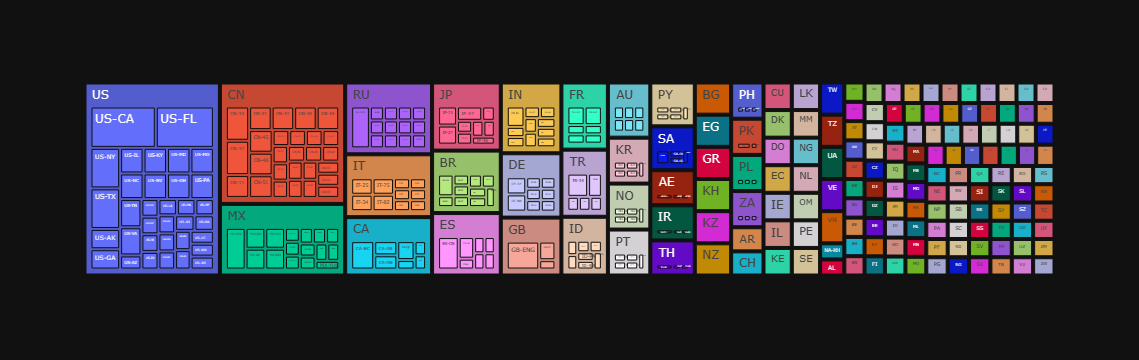

In [13]:
import plotly.express as px

fig = px.treemap(
    df,
    path=["iso_country", "iso_region"],
    values="ct",
    template="plotly_dark",
)
fig.show()

## Spark Beeline

In [14]:
%sql hive://admin@localhost:10000/default?auth=NOSASL

In [15]:
%%sql results_set <<
select iso_country, iso_region, count(*) as ct from airports where type is not null and trim(type) <> '' and type = 'large_airport' group by iso_country, iso_region order by ct desc

 * hive://admin@localhost:10000/default?auth=NOSASL
   trino://admin@trino:8080/minio?protocol=http
Done.
Returning data to local variable results_set


In [16]:
df = results_set.DataFrame()
df

iso_country iso_region  ct
0            US      US-CA   9
1            US      US-FL   8
2            GB     GB-ENG   6
3            RU     RU-MOS   4
4            CA      CA-BC   4
..          ...        ...  ..
382          CN      CN-14   1
383          US      US-IN   1
384          BH      BH-15   1
385          MX     MX-SON   1
386          BW      BW-GA   1

[387 rows x 3 columns]

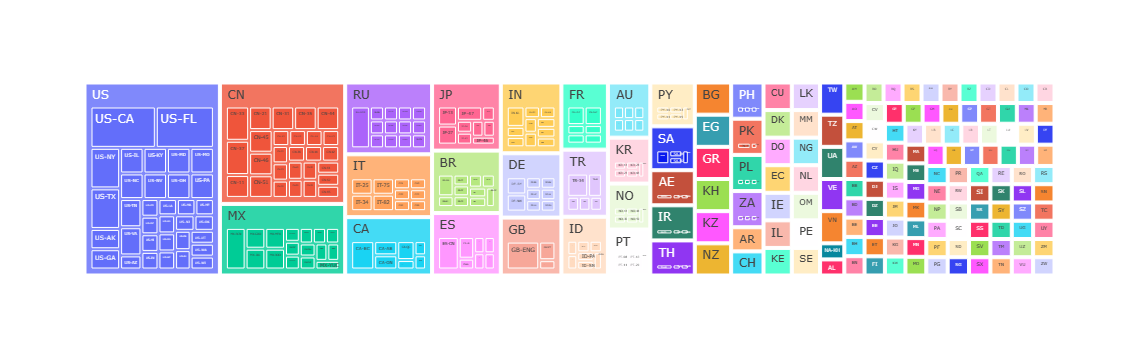

In [17]:
import plotly.express as px

fig = px.treemap(
    df,
    path=["iso_country", "iso_region"],
    values="ct",
    template="plotly",
)
fig.show()